In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, auc

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
# Path to actual data directory
data_dir = "resized_data"

# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

# Initialize mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0

# Calculate mean and std over the dataset
for images, _ in dataloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, 3, -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

# Normalize by total number of images
mean /= total_images
std /= total_images

print(f"Custom Mean: {mean}")
print(f"Custom Std: {std}")


Custom Mean: tensor([0.7038, 0.4915, 0.6227])
Custom Std: tensor([0.1703, 0.2031, 0.1734])


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7038, 0.4915, 0.6227], std=[0.1703, 0.2031, 0.1734])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Get the first image from the dataset
first_image, _ = dataset[0]

# Load the first image without any transform to show the original
original_dataset = datasets.ImageFolder(root=data_dir, transform=transforms.ToTensor())
original_image, _ = original_dataset[0]

# Print the shapes and some pixel values
print("Original Image Shape:", original_image.shape)
print("Original Image Pixel Values (first channel, first 5 pixels):", original_image[0, 0, :5])

print("Transformed Image Shape:", first_image.shape)
print("Transformed Image Pixel Values (first channel, first 5 pixels):", first_image[0, 0, :5])

Original Image Shape: torch.Size([3, 224, 224])
Original Image Pixel Values (first channel, first 5 pixels): tensor([0.9922, 1.0000, 1.0000, 0.8039, 0.6118])
Transformed Image Shape: torch.Size([3, 224, 224])
Transformed Image Pixel Values (first channel, first 5 pixels): tensor([ 1.6932,  1.7393,  1.7393,  0.5879, -0.5404])


In [5]:
print(dataset.classes)
print(f"Total samples: {len(dataset)}")

['slide_001', 'slide_002', 'slide_003', 'slide_004', 'slide_005', 'slide_006', 'slide_007', 'slide_008', 'slide_009', 'slide_010', 'slide_011', 'slide_012', 'slide_013', 'slide_014', 'slide_015', 'slide_016', 'slide_017', 'slide_018', 'slide_019', 'slide_020']
Total samples: 25045


In [6]:
# Split dataset
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.targets, random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# Print lengths
print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of val_dataset: {len(val_dataset)}")

# Print unique labels in each subset
train_labels = [dataset.targets[i] for i in train_idx]
val_labels = [dataset.targets[i] for i in val_idx]

print(f"Unique labels in train_dataset: {torch.unique(torch.tensor(train_labels))}")
print(f"Unique labels in val_dataset: {torch.unique(torch.tensor(val_labels))}")

Length of train_dataset: 20036
Length of val_dataset: 5009
Unique labels in train_dataset: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])
Unique labels in val_dataset: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])


In [ ]:
# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
model = convnext_base(weights=ConvNeXt_Base_Weights.DEFAULT)
model.classifier = nn.Identity()  # removing classifier for feature extraction
model = model.to(device)
model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [9]:
features = []
paths = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Extracting Features"):
        imgs, img_paths = batch
        imgs = imgs.to(device)
        feats = model(imgs).cpu().numpy()
        features.extend(feats)
        paths.extend(img_paths)

features = np.array(features)
print("Feature shape:", features.shape)

Extracting Features: 100%|██████████| 392/392 [1:06:19<00:00, 10.15s/it]

Feature shape: (25045, 1024, 1, 1)


In [16]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd

# Flatten the features (assuming 'features' is an array of images)
# If features is a 4D array (num_samples, height, width, channels), flatten it
flattened_features = features.reshape(features.shape[0], -1)

n_clusters = 2  # cancerous vs normal (unsupervised)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(flattened_features)

# Save image paths and cluster labels
df = pd.DataFrame({"image_path": paths, "cluster": labels})
df.to_csv("clustered_images.csv", index=False)
df.head()

,image_path,cluster
0,tensor(0),1
1,tensor(0),1
2,tensor(0),0
3,tensor(0),0
4,tensor(0),0


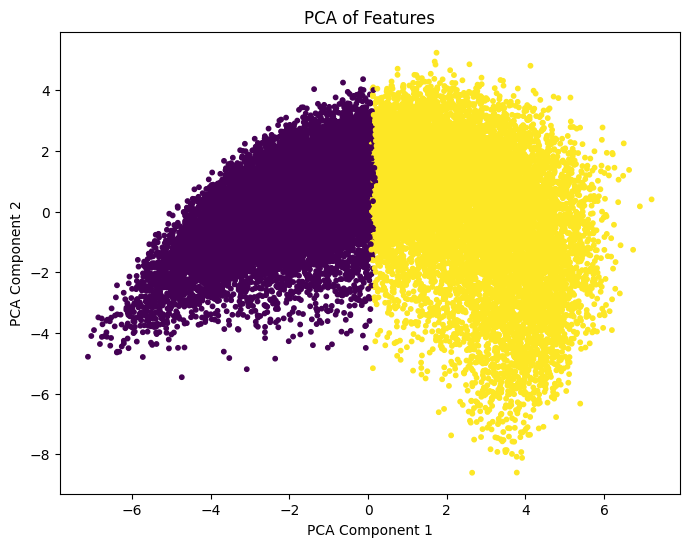

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Flatten the features if they are in 4D (e.g., [n_samples, height, width, channels])
features_2d = features.reshape(features.shape[0], -1)

# Apply PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_2d)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap="viridis", s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Features')
plt.show()


--- Evaluating Clustering against Ground Truth ---
Adjusted Rand Index (ARI): 1.000
Normalized Mutual Information (NMI): 1.000


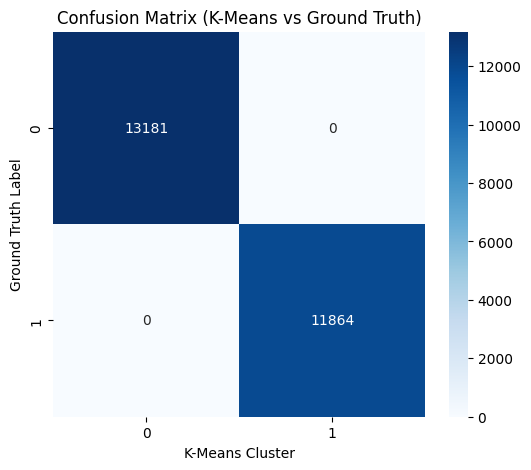


--- Classification Report (Treating Clusters as Predictions) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13181
           1       1.00      1.00      1.00     11864

    accuracy                           1.00     25045
   macro avg       1.00      1.00      1.00     25045
weighted avg       1.00      1.00      1.00     25045



In [ ]:
# Evaluating Clustering with Ground Truth
if 'labels' in locals():  # Checking if 'labels' (ground truth) exists
    print("\n--- Evaluating Clustering against Ground Truth ---")
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    ari = adjusted_rand_score(labels, kmeans.labels_)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)

    print(f"Adjusted Rand Index (ARI): {ari:.3f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(labels, kmeans.labels_)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('K-Means Cluster')
    plt.ylabel('Ground Truth Label')
    plt.title('Confusion Matrix (K-Means vs Ground Truth)')
    plt.show()

    print("\n--- Classification Report (Treating Clusters as Predictions) ---")
    print(classification_report(labels, kmeans.labels_))


--- Explained Variance Ratio ---
Explained variance ratio of first two components: 0.220, 0.096


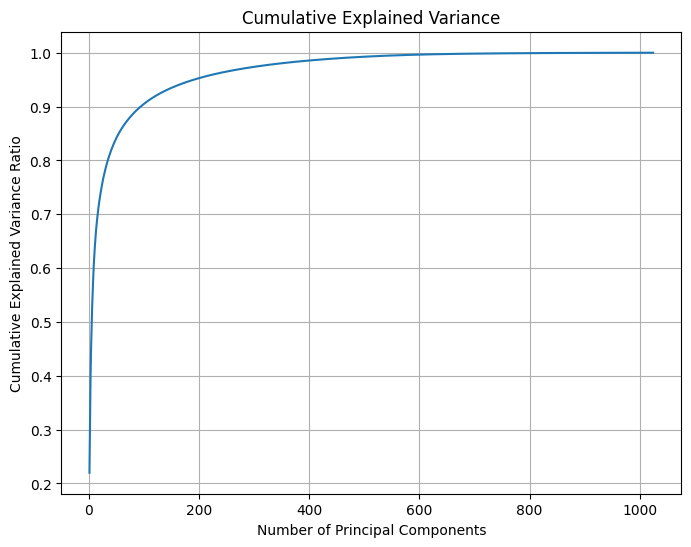

In [24]:
print("\n--- Explained Variance Ratio ---")
pca = PCA()  # Fit PCA on the original features to get explained variance
pca.fit(features.reshape(features.shape[0], -1)) # Flatten if needed
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio of first two components: {explained_variance_ratio[0]:.3f}, {explained_variance_ratio[1]:.3f}")
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()


--- Using PCA Features for Classification (Logistic Regression Example) ---
Accuracy on test set (using PCA features): 0.996

Classification Report (using PCA features):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4016
           1       1.00      1.00      1.00      3498

    accuracy                           1.00      7514
   macro avg       1.00      1.00      1.00      7514
weighted avg       1.00      1.00      1.00      7514



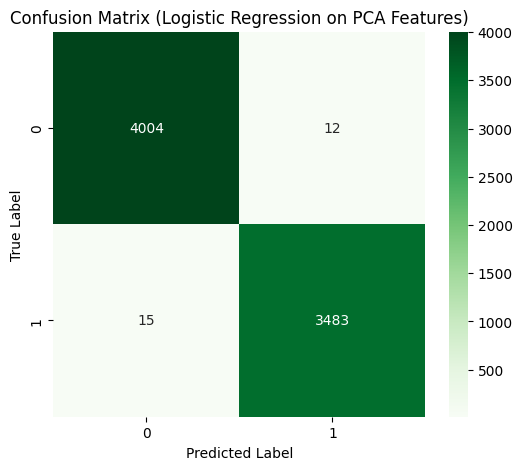


--- End of Further Analysis ---


In [20]:
print("\n--- Using PCA Features for Classification (Logistic Regression Example) ---")
if 'labels' in locals():
    X_train, X_test, y_train, y_test = train_test_split(pca_features, labels, test_size=0.3, random_state=42)

    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test set (using PCA features): {accuracy:.3f}")

    print("\nClassification Report (using PCA features):")
    print(classification_report(y_test, y_pred))

    cm_pca = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Logistic Regression on PCA Features)')
    plt.show()
else:
    print("Ground truth labels ('labels') not found. Skipping classification example.")

print("\n--- End of Further Analysis ---")


Accuracy on test set (Random Forest with 191 PCA components): 0.997

Classification Report (Random Forest with PCA):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4016
           1       1.00      1.00      1.00      3498

    accuracy                           1.00      7514
   macro avg       1.00      1.00      1.00      7514
weighted avg       1.00      1.00      1.00      7514



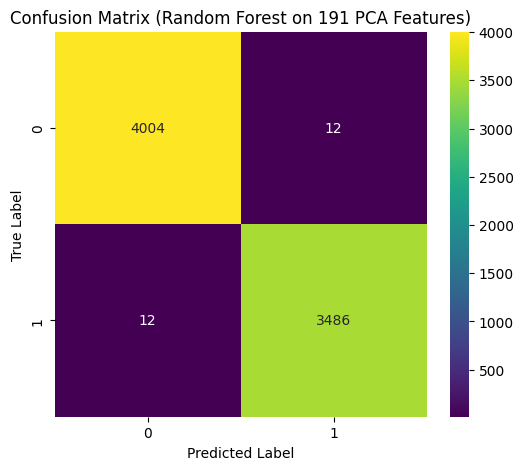

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

if 'labels' in locals():
    X_train, X_test, y_train, y_test = train_test_split(pca_features_reduced, labels, test_size=0.3, random_state=42)

    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print(f"\nAccuracy on test set (Random Forest with {n_components_chosen} PCA components): {accuracy_rf:.3f}")

    print("\nClassification Report (Random Forest with PCA):")
    print(classification_report(y_test, y_pred_rf))

    cm_rf = confusion_matrix(y_test, y_pred_rf)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='viridis')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Random Forest on {n_components_chosen} PCA Features)')
    plt.show()
else:
    print("\nGround truth labels ('labels') not found. Skipping Random Forest classification example.")


--- Cluster Statistics (Mean of Original Features) ---
             0         1         2         3         4         5         6     \
cluster                                                                         
0        0.481057  0.004227  0.091866 -0.196212  0.882134  0.357533 -0.210301   
1        0.389309 -0.089795  0.119008 -0.223080  0.654626  0.204968 -0.167408   

             7         8         9     ...      1014      1015      1016  \
cluster                                ...                                 
0       -0.058194 -0.127493 -0.139752  ... -0.245387 -0.123599  0.415986   
1       -0.209678 -0.140291 -0.062310  ... -0.372383 -0.070261  0.388459   

             1017      1018      1019      1020      1021      1022      1023  
cluster                                                                        
0        0.214523 -0.076967  0.032559 -0.144722  0.124687 -0.110187  0.184081  
1        0.182593 -0.000511 -0.016183 -0.127436  0.109619 -0.076031  0.109

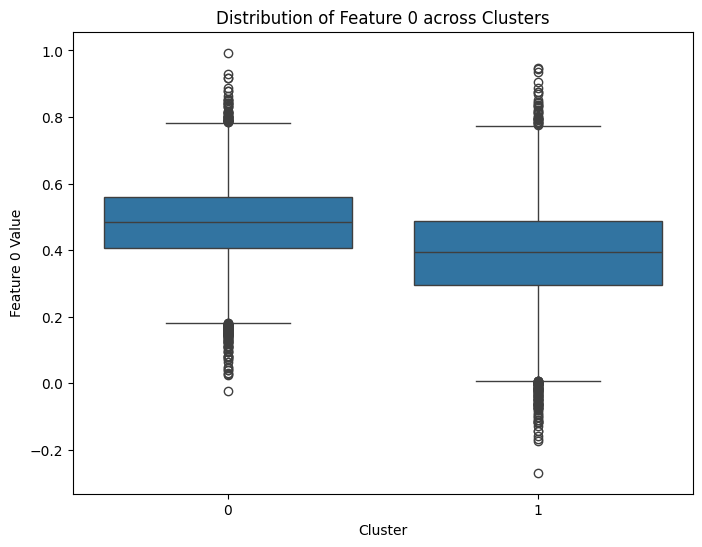

In [ ]:
import pandas as pd

# Assuming 'kmeans' is your fitted K-Means model and 'features' is your original flattened data
if 'kmeans' in locals() and 'features' in locals():
    cluster_labels = kmeans.labels_
    df = pd.DataFrame(features.reshape(features.shape[0], -1)) # Creating a DataFrame of our original features
    df['cluster'] = cluster_labels

    print("\n--- Cluster Statistics (Mean of Original Features) ---")
    print(df.groupby('cluster').mean())

    print("\n--- Cluster Statistics (Variance of Original Features) ---")
    print(df.groupby('cluster').var())

    # we can further analyze specific features per cluster
    # For example, to see the distribution of the first feature in each cluster:
    import seaborn as sns
    import matplotlib.pyplot as plt
    if df.shape[1] > 1: # Checking if there are original features
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='cluster', y=df.iloc[:, 0], data=df)
        plt.title(f'Distribution of Feature 0 across Clusters')
        plt.xlabel('Cluster')
        plt.ylabel('Feature 0 Value')
        plt.show()
else:
    print("\nK-Means model ('kmeans') or features ('features') not found.")